In [1]:
import re
import os, random
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from scikeras.wrappers import KerasClassifier

2023-06-26 16:10:47.749214: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-26 16:10:47.772351: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-26 16:10:47.772905: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 16:10:48.251570: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/marek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
RANDOM_SEED = 42
os.environ['PYTHONHASHSEED']=str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


In [5]:
from time import time
global tic
def toc(msg = "Time elapsed"):
    print(f"{msg}: {(time() - tic)*1000} ms")

### Preprocessing data

In [6]:
import chardet
with open('./dataset/sms-spam-collection-dataset/spam.csv', 'br') as file:
    b = file.read(1024*128)
    print(chardet.detect(b))

{'encoding': 'Windows-1252', 'confidence': 0.7265584523333105, 'language': ''}


In [7]:
spam = pd.read_csv('./dataset/sms-spam-collection-dataset/spam.csv', encoding="Windows-1252")  #, dtype="string")
spam

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [8]:
spam.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


#### Missing data & simple analysis

In [9]:
# Inspect missing data columns
spam[spam['Unnamed: 2'].notna() | spam['Unnamed: 3'].notna() | spam['Unnamed: 4'].notna()].head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
444,ham,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...,HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...,NaN,NaN
671,spam,SMS. ac sun0819 posts HELLO:\You seem cool,"wanted to say hi. HI!!!\"" Stop? Send STOP to ...",NaN,NaN
710,ham,Height of Confidence: All the Aeronautics prof...,"this wont even start........ Datz confidence..""",NaN,NaN


In [10]:
print('Missing data in v1, v2:', (spam[spam['v1'].isna()].size, spam[spam['v2'].isna()].size))
df = spam.drop(labels=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df = df.rename(columns={'v1': 'label', 'v2':'message'})
df

Missing data in v1, v2: (0, 0)


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


Text(0.5, 1.0, 'Ham vs spam')

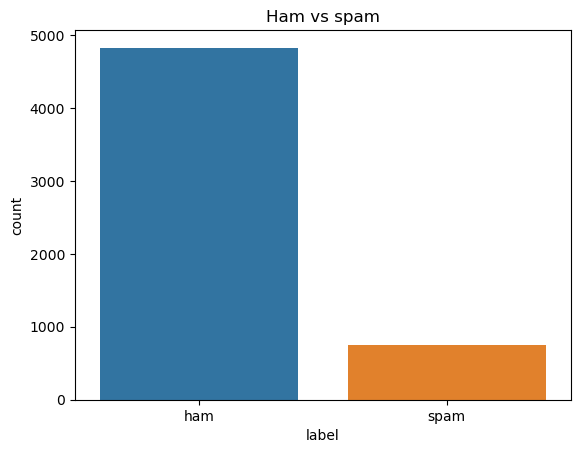

In [11]:
# Count of labeled ham/spam messages
sns.countplot(x=df.label, data=df)
plt.title('Ham vs spam')

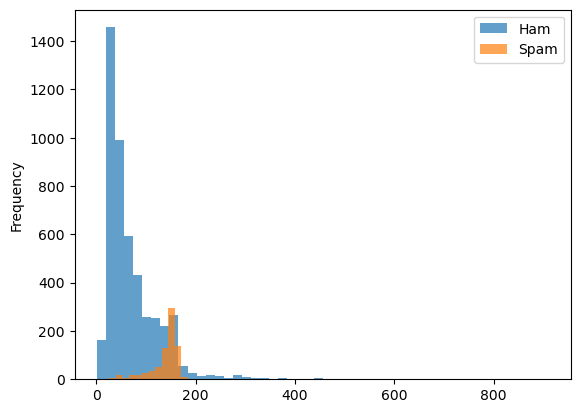

In [12]:
df['message_len'] = df.message.str.len()

df[df.label == 'ham'].message_len.plot(kind='hist', bins=50, alpha=0.7, label='Ham')
df[df.label == 'spam'].message_len.plot(kind='hist', bins=16, alpha=0.7, label='Spam')
plt.legend()
plt.show()

#### Clean text data

 * lowercase
 * split by words
 * remove non-alphanumeric characters - both punctuation and badly decoded characters like _å_
 * remove stop-words - most common words like (a, the, he, she) that doesn't provide significant information

In [13]:
# test function using build-in Python methods
example_msg_indexes = [12,4,18]

def clean_text_python(s):
    s = s.lower()
    s = re.sub('[^a-z0-9]', ' ', s) # replacing with a space so that e.g. "I'm" will be split into 2 words
    s = s.strip()
    s = re.split('\s+', s)
    return ' '.join(s)

def test_clean_text(s):
    clean = clean_text_python(s)
    print(f'Original: "{s}"')
    print(f'Clean   : "{clean}"')
    print()
for i in example_msg_indexes:
    test_clean_text(df.iloc[i].message)
tic = time()
df.message.apply(clean_text_python)
toc("apply(clean_text)")

Original: "URGENT! You have won a 1 week FREE membership in our å£100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18"
Clean   : "urgent you have won a 1 week free membership in our 100 000 prize jackpot txt the word claim to no 81010 t c www dbuk net lccltd pobox 4403ldnw1a7rw18"

Original: "Nah I don't think he goes to usf, he lives around here though"
Clean   : "nah i don t think he goes to usf he lives around here though"

Original: "Fine if thatåÕs the way u feel. ThatåÕs the way its gota b"
Clean   : "fine if that s the way u feel that s the way its gota b"

apply(clean_text): 34.89565849304199 ms


In [14]:
eng_stopwords = stopwords.words('english') + ['r', 'u', 'ru', 'ure']
print('Stop-words:', eng_stopwords)

def clean_text_pandas(df: pd.DataFrame):
    df['message_cleaned'] = (
      df.message
        .str.lower()
        .str.replace('[^a-z0-9]', ' ', regex=True)
        .str.strip()
        .str.split('\s+', regex=True)
        .apply(lambda word_list: list(filter(lambda x: x not in eng_stopwords, word_list)))
        .str.join(' ')
    )

tic = time()
clean_text_pandas(df)
toc("clean_text_pandas")

print()
for i in example_msg_indexes:
    print(f'Original: "{df.iloc[i].message}"')
    # print(f'Clean   : "{clean_df.iloc[i].message}"')
    print(f'Clean   : "{df.iloc[i].message_cleaned}"')
    print()

df.label.replace({"spam": 1, "ham": 0}, inplace=True)
df

Stop-words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

,label,message,message_len,message_cleaned
0,0,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,29,ok lar joking wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,49,dun say early hor c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,nah think goes usf lives around though
...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,2nd time tried 2 contact 750 pound prize 2 cla...
5568,0,Will Ì_ b going to esplanade fr home?,37,b going esplanade fr home
5569,0,"Pity, * was in mood for that. So...any other s...",57,pity mood suggestions
5570,0,The guy did some bitching but I acted like i'd...,125,guy bitching acted like interested buying some...


#### Vectorization

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df.message_cleaned, df.label)
print(X_train.shape, X_test.shape)

(4179,) (1393,)


In [16]:
count_vectorizer = CountVectorizer()
# vectorizer = CountVectorizer(ngram_range=(1, 2), token_pattern=r"\b\w+\b", min_df=1)
# vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(2, 2))

X_train_vectorized = count_vectorizer.fit_transform(X_train)
X_test_vectorized = count_vectorizer.transform(X_test)

### Models

 * decission tree
 * SVC
 * logictic regression
 * multinomial Naive Bayess
 * neural network

#### Scikit-learn models

In [17]:
plt.rcParams['figure.figsize'] = [4, 4]

kfold = KFold(n_splits=5)

trained_models = []
_trained_models_columns = ['Name', 'Accuracy', 'Precision', 'Recall', 'model']

def train_model(model, params_grid, name=None, vectorizer=count_vectorizer, scaler=StandardScaler(with_mean=False), hidden=False):
    pipe = Pipeline([
        ('vectorizer', vectorizer),
        ('scaler', scaler),
        ('model', model),
    ])

    grid = GridSearchCV(pipe, params_grid, cv=kfold, refit=True, return_train_score=True)

    %time grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)
    
    acc = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)

    print("\nAccuracy:", acc)
    print("Best score:", grid.best_score_)
    print("Best score:", grid.best_params_)

    if not hidden:
        if name is None:
            name = str(model)
        trained_models.append([name, acc, precision, recall, grid.best_estimator_['model']])

        cm = metrics.confusion_matrix(y_test, y_pred)
        metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()
        plt.show()
    
    return grid.best_estimator_

def train_model_simple(model, name):
    %time model.fit(X_train_vectorized, y_train)
    y_pred = model.predict(X_test_vectorized)
    acc = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    trained_models.append([name, acc, precision, recall, model])
    print("\nAccuracy:", metrics.accuracy_score(y_test, y_pred))
    cm = metrics.confusion_matrix(y_test, y_pred)
    metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.show()
    return model

def get_trained_models_df():
    return pd.DataFrame(data=trained_models, columns=_trained_models_columns)

**Decision tree:**

CPU times: user 9.18 s, sys: 381 µs, total: 9.18 s
Wall time: 9.24 s

Accuracy: 0.9641062455132807
Best score: 0.9691295877145232
Best score: {'model__criterion': 'entropy', 'model__max_depth': 30}


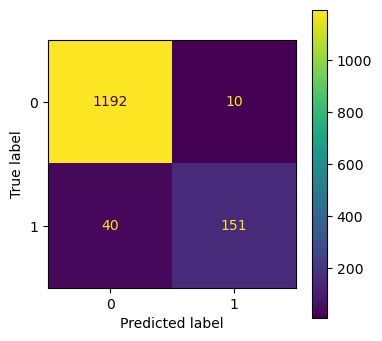

Tree depth: 30
Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('scaler', StandardScaler(with_mean=False)),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=30))])


In [18]:
from sklearn.tree import DecisionTreeClassifier

tree = train_model(DecisionTreeClassifier(), name="Decision tree", params_grid={
    "model__criterion": ['gini', 'entropy', 'log_loss'],
    "model__max_depth": [None] + list(range(5, 50, 5)),
})
print("Tree depth:", tree['model'].get_depth())
print(tree)

**Support vector clustering (SVC):**

In [19]:
from sklearn.svm import SVC

prev_svc = train_model(SVC(), name='SVC', params_grid={
    "model__kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
}, hidden=True)

CPU times: user 13.8 s, sys: 69.9 ms, total: 13.9 s
Wall time: 13.9 s

Accuracy: 0.9777458722182341
Best score: 0.9770274761481822
Best score: {'model__kernel': 'sigmoid'}


CPU times: user 14.5 s, sys: 2.94 ms, total: 14.5 s
Wall time: 14.5 s

Accuracy: 0.9777458722182341
Best score: 0.9770274761481822
Best score: {'model__C': 1}


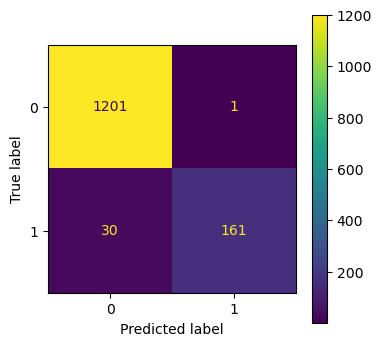

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('scaler', StandardScaler(with_mean=False)),
                ('model', SVC(C=1, kernel='sigmoid'))])

In [20]:
best_kernel = prev_svc.get_params()['model__kernel']
train_model(SVC(kernel=best_kernel), {
    "model__C": [0.01, 0.1, 1, 2, 5, 10],
})

**Logistic regression:**

/home/marek/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


CPU times: user 6.47 s, sys: 40.7 ms, total: 6.51 s
Wall time: 6.51 s

Accuracy: 0.9727207465900933
Best score: 0.977026903131536
Best score: {'model__C': 10, 'model__penalty': 'l1'}


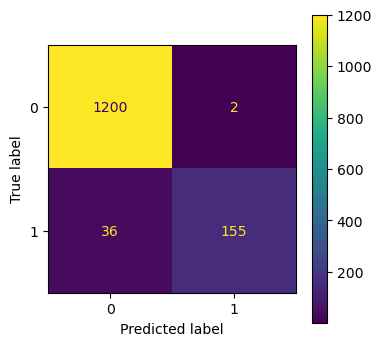

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('scaler', StandardScaler(with_mean=False)),
                ('model',
                 LogisticRegression(C=10, penalty='l1', solver='liblinear'))])

In [21]:
from sklearn.linear_model import LogisticRegression

# train_simple(LogisticRegression())
train_model(LogisticRegression(solver="liblinear"), name="Logistic regression", params_grid={
    "model__penalty": ['l1', 'l2'],
    "model__C": list(map(lambda x: 10**x, range(-2,10))),
})

**Multinomial Naive Bayess:**

CPU times: user 1.76 s, sys: 36.9 ms, total: 1.8 s
Wall time: 1.76 s

Accuracy: 0.95908111988514
Best score: 0.9617133197719394
Best score: {'model__alpha': 6}


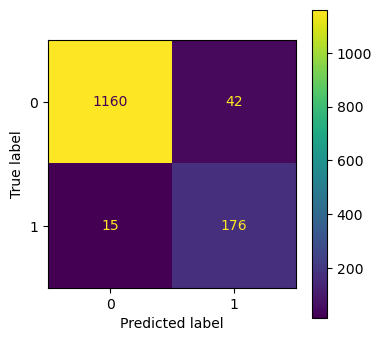

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('scaler', StandardScaler(with_mean=False)),
                ('model', MultinomialNB(alpha=6))])

In [22]:
from sklearn.naive_bayes import MultinomialNB

train_model(MultinomialNB(), name="MultinomialNB", params_grid={
    "model__alpha": range(1,10),
})

CPU times: user 1.18 ms, sys: 3.96 ms, total: 5.14 ms
Wall time: 1.65 ms

Accuracy: 0.9813352476669059


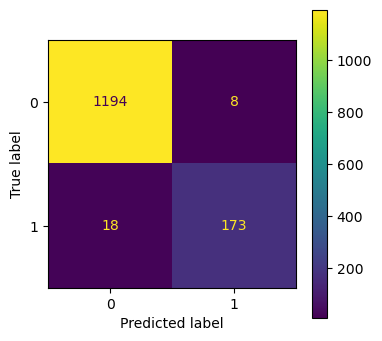

MultinomialNB()

In [23]:
# training with default parameters without GridSearchCV nor StandardScaler
train_model_simple(MultinomialNB(), name='MultinomialNB w/o standard scaler')

#### Neural networks:

In [24]:
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping, History
import keras.metrics

def train_keras_model(model, name = 'Neural network'):
    early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    history = History()
    %time model.fit(X_train_vectorized.toarray(), y_train, epochs=20, callbacks=[early_stopping, history])
    
    loss, acc, recall, precision = model.evaluate(X_test_vectorized.toarray(), y_test)
    trained_models.append([name, acc, precision, recall, model])

    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

**Simple network:**

In [25]:
keras.backend.clear_session()
print([X_train_vectorized.shape, y_train.shape])

def create_nn_model_simple(X_train_vectorized):
    n_features = X_train_vectorized.shape[1]

    nn_model_simple = Sequential()
    nn_model_simple.add(Dense(64, activation="relu", input_shape=(n_features,)))
    nn_model_simple.add(Dense(128, activation="relu"))
    nn_model_simple.add(Dense(1, activation="sigmoid"))

    nn_model_simple.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            'accuracy',
            keras.metrics.Recall(),
            keras.metrics.Precision(),
        ],
    )

    nn_model_simple.summary()
    return nn_model_simple

nn_model_simple = create_nn_model_simple(X_train_vectorized)

[(4179, 7260), (4179,)]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                464704    
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 473,153
Trainable params: 473,153
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
131/131 [==============================] - 1s 2ms/step - loss: 0.2390 - accuracy: 0.9273 - recall: 0.4784 - precision: 0.9500
Epoch 2/20
131/131 [==============================] - 0s 2ms/step - loss: 0.0195 - accuracy: 0.9947 - recall: 0.9712 - precision: 0.9890
Epoch 3/20
131/131 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 0.9995 - recall: 0.9982 - precision: 0.9982
Epoch 4/20
131/131 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 0.9998 - recall: 0.9982 - precision: 1.0000
Epoch 5/20
131/131 [==============================] - 0s 2ms/step - loss: 6.5971e-04 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 6/20
131/131 [==============================] - 0s 2ms/step - loss: 3.6088e-04 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 7/20
131/131 [==============================] - 0s 2ms/step - loss: 2.3719e-04 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 8/20
131/131 [=========

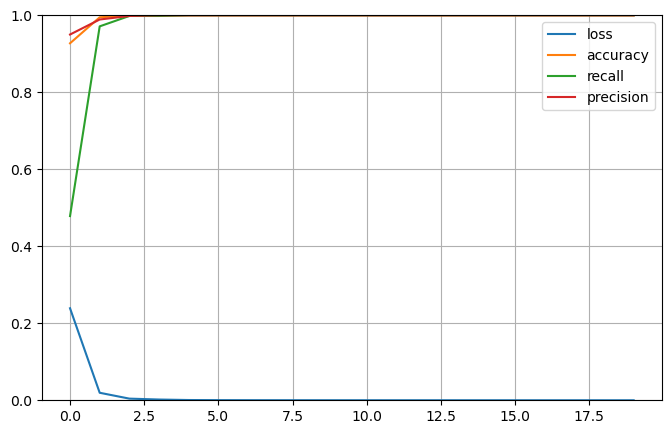

In [26]:
train_keras_model(nn_model_simple, 'Simple neural network')

**Network with added batch normalization & dropout:**

In [27]:
# keras.backend.clear_session()
print([X_train_vectorized.shape, y_train.shape])

n_features = X_train_vectorized.shape[1]

nn_model_norm = Sequential()
nn_model_norm.add(Dense(64, activation='relu', input_shape=(n_features,)))
nn_model_norm.add(BatchNormalization())
nn_model_norm.add(Dropout(0.1))
nn_model_norm.add(Dense(128, activation='relu'))
nn_model_norm.add(BatchNormalization())
nn_model_norm.add(Dropout(0.1))
nn_model_norm.add(Dense(1, activation='sigmoid'))

nn_model_norm.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        'accuracy',
        keras.metrics.Recall(),
        keras.metrics.Precision(),
    ],
)

nn_model_norm.summary()

[(4179, 7260), (4179,)]
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                464704    
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (

Epoch 1/20
131/131 [==============================] - 1s 2ms/step - loss: 0.2628 - accuracy: 0.9036 - recall_1: 0.9137 - precision_1: 0.5886
Epoch 2/20
131/131 [==============================] - 0s 2ms/step - loss: 0.0590 - accuracy: 0.9868 - recall_1: 0.9622 - precision_1: 0.9402
Epoch 3/20
131/131 [==============================] - 0s 2ms/step - loss: 0.0275 - accuracy: 0.9940 - recall_1: 0.9748 - precision_1: 0.9801
Epoch 4/20
131/131 [==============================] - 0s 2ms/step - loss: 0.0277 - accuracy: 0.9919 - recall_1: 0.9874 - precision_1: 0.9531
Epoch 5/20
131/131 [==============================] - 0s 2ms/step - loss: 0.0128 - accuracy: 0.9978 - recall_1: 0.9910 - precision_1: 0.9928
Epoch 6/20
131/131 [==============================] - 0s 2ms/step - loss: 0.0066 - accuracy: 0.9983 - recall_1: 0.9946 - precision_1: 0.9928
Epoch 7/20
131/131 [==============================] - 0s 2ms/step - loss: 0.0083 - accuracy: 0.9976 - recall_1: 0.9964 - precision_1: 0.9858
Epoch 8/20
13

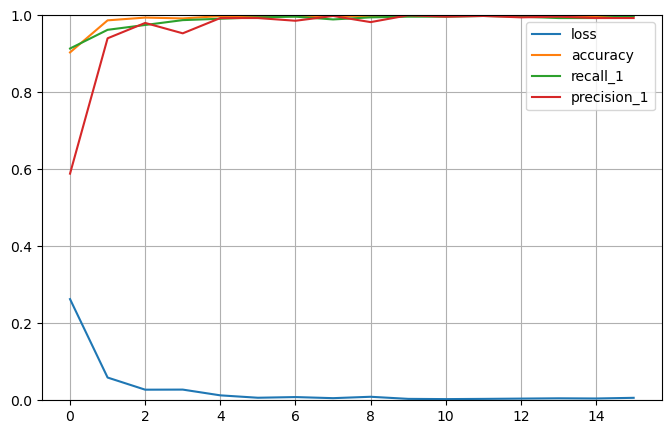

In [28]:
train_keras_model(nn_model_norm, 'Neural network w/batch norm')

### Models comparison

In [29]:
trained_models_df = get_trained_models_df().sort_values(by="Accuracy", ascending=False)
print(trained_models_df.loc[0].model)
trained_models_df

DecisionTreeClassifier(criterion='entropy', max_depth=30)


,Name,Accuracy,Precision,Recall,model
6,Neural network w/batch norm,0.982053,1.000000,0.869110,<keras.engine.sequential.Sequential object at ...
4,MultinomialNB w/o standard scaler,0.981335,0.955801,0.905759,MultinomialNB()
5,Simple neural network,0.979900,1.000000,0.853403,<keras.engine.sequential.Sequential object at ...
1,SVC(kernel='sigmoid'),0.977746,0.993827,0.842932,"SVC(C=1, kernel='sigmoid')"
2,Logistic regression,0.972721,0.987261,0.811518,"LogisticRegression(C=10, penalty='l1', solver=..."
0,Decision tree,0.964106,0.937888,0.790576,"DecisionTreeClassifier(criterion='entropy', ma..."
3,MultinomialNB,0.959081,0.807339,0.921466,MultinomialNB(alpha=6)


### Tuning vectorizer

For the best models we try to tune the text vectorizer parameters:
 * **n-grams** (`ngram_range`) – we can try to generate not ony unigrams as by default but for larger n-grams, so that order of words in the sentence will not be lost during vectorization
 * **min/max document frequencies** (`min_df`, `max_df`) – words which occur with high frequency in the corpus are most likely not to proivde meaningful information for the model

In [30]:
vectorizer_params_grid = {
    "vectorizer__analyzer": ["word", "char_wb"],
    "vectorizer__ngram_range": [(1,1), (2,2), (3,3), (1,2), (1,3)],
    # "vectorizer__max_df": np.linspace(0.125, 1, 5),
}

Tested models:
 * multinomial Naive Bayess (w/o StandardScaler)
 * SVC
 * NN w/batch normalization

In [31]:
def get_trained_model(i):
    print(trained_models_df.loc[i])
    print()
    # return trained_models_df[trained_models_df.Name == name].model.iloc[0]
    return trained_models_df.loc[i].model

**Multinomial Naive Bayess (w/o standard scaler)**

Name         MultinomialNB w/o standard scaler
Accuracy                              0.981335
Precision                             0.955801
Recall                                0.905759
model                          MultinomialNB()
Name: 4, dtype: object

CPU times: user 6.01 s, sys: 7.75 ms, total: 6.02 s
Wall time: 6.04 s

Accuracy: 0.9820531227566404
Best score: 0.9870784746296881
Best score: {'vectorizer__analyzer': 'word', 'vectorizer__ngram_range': (1, 2)}


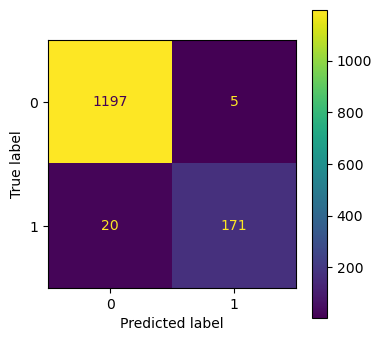

Pipeline(steps=[('vectorizer', CountVectorizer(ngram_range=(1, 2))),
                ('scaler', None), ('model', MultinomialNB())])

In [32]:
multinomial_nb_model = get_trained_model(4)
train_model(multinomial_nb_model, name="MultinomialNB (n-grams)", scaler=None, params_grid=vectorizer_params_grid)

**SVC**

Name              SVC(kernel='sigmoid')
Accuracy                       0.977746
Precision                      0.993827
Recall                         0.842932
model        SVC(C=1, kernel='sigmoid')
Name: 1, dtype: object

CPU times: user 55.5 s, sys: 370 ms, total: 55.8 s
Wall time: 56 s

Accuracy: 0.9842067480258435
Best score: 0.9830094834254934
Best score: {'vectorizer__analyzer': 'char_wb', 'vectorizer__ngram_range': (3, 3)}


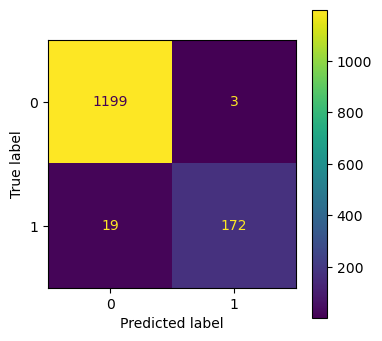

Pipeline(steps=[('vectorizer',
                 CountVectorizer(analyzer='char_wb', ngram_range=(3, 3))),
                ('scaler', StandardScaler(with_mean=False)),
                ('model', SVC(C=1, kernel='sigmoid'))])

In [33]:
svc_model = get_trained_model(1)
train_model(svc_model, name="SVC (n-grams)", params_grid=vectorizer_params_grid)

**Neural network with batch normalization**

In [34]:
# early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
# nn_model_simple_classifier = KerasClassifier(model=nn_model_simple, epochs=20, optimizer='adam', callbacks=[early_stopping], verbose=0)
# train_model(nn_model_simple_classifier, vectorizer=CountVectorizer(max_features=7260), params_grid=vectorizer_params_grid)

In [35]:
# Before vectorizer tuning
before = get_trained_models_df().iloc[[4,1]]
before

,Name,Accuracy,Precision,Recall,model
4,MultinomialNB w/o standard scaler,0.981335,0.955801,0.905759,MultinomialNB()
1,SVC(kernel='sigmoid'),0.977746,0.993827,0.842932,"SVC(C=1, kernel='sigmoid')"


In [36]:
# After vectorizer tuning
after = get_trained_models_df().iloc[7:]
after

,Name,Accuracy,Precision,Recall,model
7,MultinomialNB (n-grams),0.982053,0.971591,0.895288,MultinomialNB()
8,SVC (n-grams),0.984207,0.982857,0.900524,"SVC(C=1, kernel='sigmoid')"


### Summary

The tested models all performed well for given dataset with accuracy >95% for each of them. Adding StandardScaler helps with machine learning algorithms provided by scikit-learn such as decision tree, logistic regression or SVC, with one exception for multinomial Naive Bayess where using standard scaler caused the estimator to drop the accuracy from 98% to 95% performing worst among all models.  
  
Neural network after adding batch normalization and dropout scored better then rest of the models with default text vectorizer. However, after tuning the vectorizer by adding n-grams, both SVC and MultinomialNB without standard scaler outperformed both neural networks with less training time. Tuning vectorizer for neural networks could also improve its performance, but wasn't tested because of long training times.  
  
Neural networks scored 1.0 precision, which means that there were no false positive so that potential user can have confidence that there will be mostly spam in the spam folder. However, depending on the situation we could argue that in case of spam detection recall is more important metric. High recall values means that there are little spam undetected. Because of that we could make decision to use MultinomialNB model despite lowest accuracy, because of high recall.

In [37]:
get_trained_models_df().sort_values(by="Accuracy", ascending=False)

,Name,Accuracy,Precision,Recall,model
8,SVC (n-grams),0.984207,0.982857,0.900524,"SVC(C=1, kernel='sigmoid')"
7,MultinomialNB (n-grams),0.982053,0.971591,0.895288,MultinomialNB()
6,Neural network w/batch norm,0.982053,1.000000,0.869110,<keras.engine.sequential.Sequential object at ...
4,MultinomialNB w/o standard scaler,0.981335,0.955801,0.905759,MultinomialNB()
5,Simple neural network,0.979900,1.000000,0.853403,<keras.engine.sequential.Sequential object at ...
1,SVC(kernel='sigmoid'),0.977746,0.993827,0.842932,"SVC(C=1, kernel='sigmoid')"
2,Logistic regression,0.972721,0.987261,0.811518,"LogisticRegression(C=10, penalty='l1', solver=..."
0,Decision tree,0.964106,0.937888,0.790576,"DecisionTreeClassifier(criterion='entropy', ma..."
3,MultinomialNB,0.959081,0.807339,0.921466,MultinomialNB(alpha=6)


<Axes: xlabel='Accuracy', ylabel='Name'>

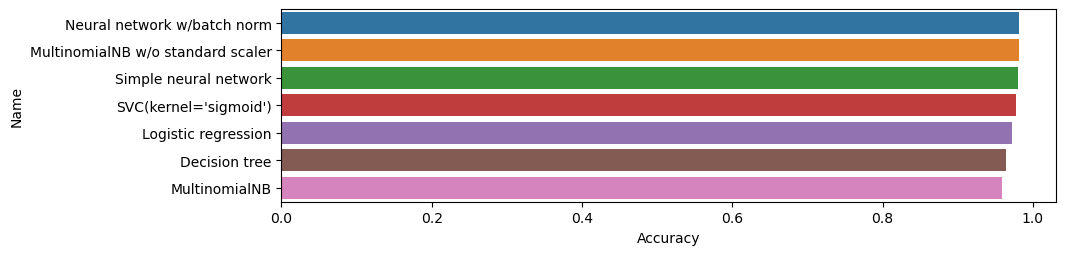

In [38]:
plt.rcParams['figure.figsize'] = [10, 2.5]
sns.barplot(y='Name', x='Accuracy', data=trained_models_df, orient='h')

<Axes: xlabel='Precision', ylabel='Name'>

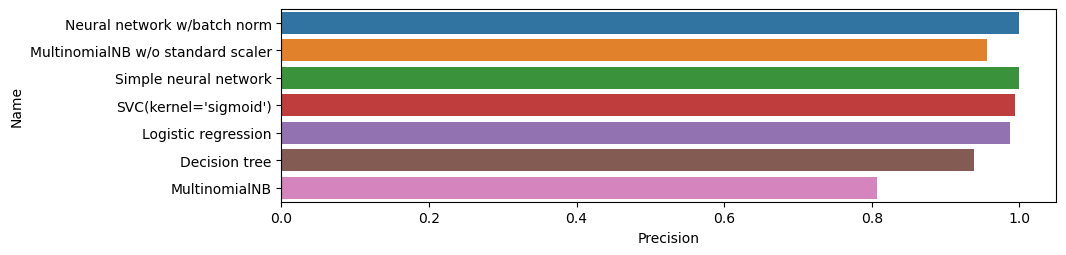

In [39]:
sns.barplot(y='Name', x='Precision', data=trained_models_df, orient='h')

<Axes: xlabel='Recall', ylabel='Name'>

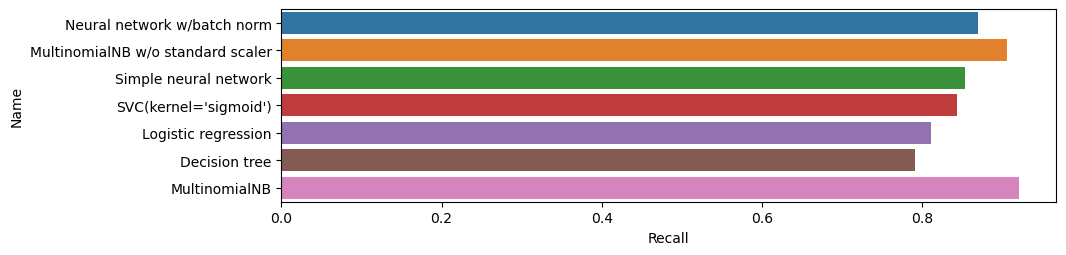

In [40]:
sns.barplot(y='Name', x='Recall', data=trained_models_df, orient='h')

_TODO test 2 best models on my priv SMSes?_